# REINFORCE with baseline

An implementation of REINFORCE with baseline, following Sutton & Barto Section 13.4:

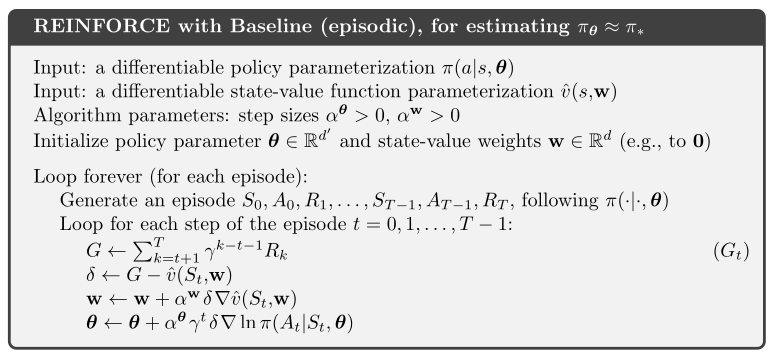

We start with the previous notebook (REINFORCE without baseline) and introduce a number of changes:

* Use of baseline, i.e., use of a separate learned function on the observations that takes scalar values that we deduct from the total reward per episode,
  
* Use of more complicated [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/) environment,
  
* Use of a similar policy network structure as in PPO.

Each change in the algorithm seems to require new hyper-parameters. This is why we also provide a tiny utility that allows scheduling several runs with different parameters.

In [1]:
import gymnasium as gym

import numpy as np

import torch
from torch import nn

In [2]:
# We follow the specification of PPO: 
# "To represent the policy, we used a fully-connected MLP with two hidden layers of 64 units, and tanh nonlinearities [...]"
# applied to discrete actions (PPO uses continuous actions)
class Policy(nn.Module):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, n_hidden1),
            nn.Tanh(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.Tanh(),
            nn.Linear(n_hidden2, n_out),
        )
        self.sm = nn.Softmax(dim=0) # probabilities to choose an action
        self.lsm = nn.LogSoftmax(dim=0) # for log probabilities used in the gradient for REINFORCE
    
    def forward(self, x): 
        logits = self.net(x)
        probs = self.sm(logits)
        scores = self.lsm(logits)
        return probs, scores, logits # we include the logits in the output for use as a state-value function

In [3]:
seed = 42
env_name = "LunarLander-v3"

n_hidden1 = 64 
n_hidden2 = 64

gamma = 0.9995
alpha = 8e-06

# Sutton & Barto use a separate learning rate to update the state-value function parameters
alpha_value = 4e-05

n_episodes = 14000
print_every_n_episodes = 500

In [4]:
np.random.seed(seed)
torch.manual_seed(seed)

# Initialise the environment
env = gym.make(env_name)

# Reset the environment to generate the first observation
observation, info = env.reset(seed=seed)
observation = torch.tensor(observation, requires_grad=False) # the policy expects tensors as input

policy = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=env.action_space.n)

# The state-value function maps states to a single number. From PPO: "We don’t share parameters between the policy and value function [...]". 
value = Policy(n_in=env.observation_space.shape[0], n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_out=1)

# Sutton & Barto use separate gradient update steps with separate learning rates for the policy and the state-value function
optimizer = torch.optim.SGD(policy.parameters(), lr=alpha, maximize=True)
optimizer_value = torch.optim.SGD(value.parameters(), lr=alpha_value, maximize=True)


all_episode_rewards = []

for i_episode in range(1, n_episodes+1):
    
    rewards = [] # T rewards from 1 to T
    observations = [observation] # T observations from 0 to T-1
    actions = [] # T actions from 0 to T-1

    # roll-out of one episode following the policy
    done = False
    while not done:
        
        # probabilities for actions, we use the probabilities (softmax) here, and the score (log softmax) later for the gradient
        pred_probab, pred_score, policy_logits = policy(observation)
        
        # sample an action according to the probabilities
        action = np.random.choice(len(pred_probab), 1, p=pred_probab.detach().numpy()) 

        # step (transition) through the environment with the action
        # receiving the next observation, reward and if the episode has terminated or truncated
        observation, reward, terminated, truncated, info = env.step(action.item())
        observation = torch.tensor(observation, requires_grad=False) # TODO: check that environment returns tensors, or policy converts input in forward
        done = terminated or truncated

        # build up one episode
        rewards.append(reward)
        observations.append(observation)
        actions.append(action)

        # If the episode has ended then we can reset to start a new episode
        if done:
            observation, info = env.reset()
            all_episode_rewards.append(sum(rewards)) # track total reward for all episodes

    
    # policy updates using policy gradients along each step of the episode
    for t in range(len(rewards)):
        
        # observation at step t during episode, and action taken
        observation = observations[t]
        action = actions[t] 
        
        # discounted return starting from step t
        G = sum(gamma**i * r for i, r in enumerate(rewards[t:]))
        
        # removing the baseline
        _, _, value_logit = value(observation)
        delta = G - value_logit
        
        # note that delta does not only depend on the rewards (through G), but also on the parameters of the state-value network (through the value logits)
        # note however, that we don't take the gradient of them
        delta = delta.detach()

        # this is the probability but under the policy that was updated along the episode
        pred_probab, pred_score, policy_logits = policy(observation)

        # but we want the updated probability of the action that was actually taken 
        log_pi_at_st_theta = pred_score[action] 

        pseudo_loss = gamma**t * delta * log_pi_at_st_theta # replaced G by delta = G - value function
        
        value_pseudo_loss = delta * value_logit # note that we only want the gradient to include the value function logits, not the deltas
        
        # We now include a gradient step (also a maximization) of the value function,
        optimizer_value.zero_grad()
        value_pseudo_loss.backward()
        optimizer_value.step()

        optimizer.zero_grad()
        pseudo_loss.backward()
        optimizer.step()
    

    # print some statistics every other episode
    if i_episode % print_every_n_episodes == 0:
        print("\nEpisode:", i_episode, "of", n_episodes)
        print("Total return in this episode:", sum(rewards))
        print("State-value function for initial observation in this episode:", value(observations[0])[2].item())
        if len(all_episode_rewards) > 100: print("Average return last 100 episodes:", np.mean(all_episode_rewards[-100:]))


env.close()


Episode: 500 of 14000
Total return in this episode: -131.93295369654368
State-value function for initial observation in this episode: -86.77642822265625
Average return last 100 episodes: -132.4217114111194

Episode: 1000 of 14000
Total return in this episode: -100.85448047001509
State-value function for initial observation in this episode: -89.34101867675781
Average return last 100 episodes: -115.12079834267591

Episode: 1500 of 14000
Total return in this episode: -88.33063411851255
State-value function for initial observation in this episode: -92.60932159423828
Average return last 100 episodes: -112.118995189582

Episode: 2000 of 14000
Total return in this episode: -103.53539148513124
State-value function for initial observation in this episode: -67.86618041992188
Average return last 100 episodes: -96.97195719973627

Episode: 2500 of 14000
Total return in this episode: -50.004623363188486
State-value function for initial observation in this episode: -69.10685729980469
Average return 

### Save and load trained policies

In [5]:
import pickle

# Uncomment to save a trained policy:
# pickle.dump(policy, open('policies/REINFORCE_with_baseline_LunarLander_best.pkl', 'wb'))

# Uncomment to load a saved policy:
# policy = pickle.load(open('policies/REINFORCE_with_baseline_LunarLander_best.pkl', 'rb'))

### Plotting training progress

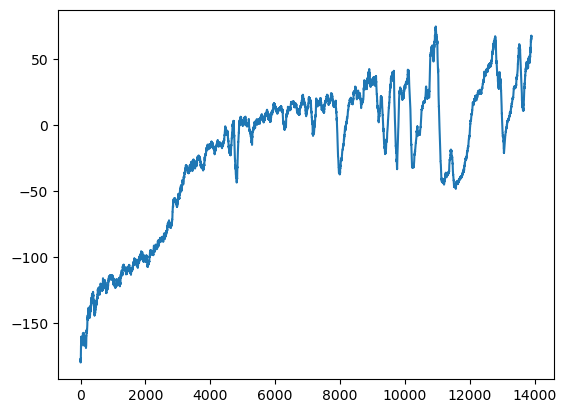

In [9]:
import matplotlib.pyplot as plt
smoothing_interval = 100 # Change for different levels of smoothing
smoothed_rewards = np.convolve(all_episode_rewards, np.ones(smoothing_interval)/smoothing_interval, 'valid')

plt.plot(smoothed_rewards)

Note that while we sometimes get a total reward per episode of more than the environment threshold (200 in this case), the environment would only be considered fully solved if it is solved on average over many episodes. From the [OpenAI Gym leaderboard](https://github.com/openai/gym/wiki/Leaderboard#cartpole-v0):

>  LunarLander-v2 defines "solving" as getting average reward of 200 over 100 consecutive trials.

The best I got was around 60 average reward over 100 episodes.

## Visualize the policy


In [10]:
# Initialise the environment
env = gym.make(env_name, render_mode="human")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)

done = False
while not done:

    pred_probab, pred_score, _ = policy(torch.tensor(observation, requires_grad=False)) # TODO: separate value network maybe better so we don't need to change this code
    action = pred_probab.argmax() # TODO: should sampling also be stochastic?

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action.item())
    
    # If the episode has ended then we can reset to start a new episode
    done = terminated or truncated
    if done:
        observation, info = env.reset()

env.close()

## Exercises

1. Consider the observation space for LunarLander. How big would the policy network need to be to solve the environment? Can the continous observation space be approximately described by a number of distinct discrete observations? Think of a suicide burn (main engine ignited at the very last moment). How many are distinct states are needed to describe such a trajectory? For example, in the x coordinate, the policy should be able to encode states such as "early" (don't fire the main engire), "late" (fire), and "landed" (stop firing again).

2. Try to solve the CartPole environment with REINFORCE with baseline in as few episodes as possible. Compare to REINFORCE (without baseline).

    From the [OpenAI Gym leaderboard](https://github.com/openai/gym/wiki/Leaderboard#cartpole-v0) (no longer maintained):

    > CartPole-v0 defines "solving" as getting average reward of 195.0 over 100 consecutive trials.

3. Can you beat 60 average reward over 100 episodes for LunarLander?

## Optional: Hyperparameter search in parallel

Even with just a few parameters (two different learning rates for policy and state-value function, and the discount factor), manually finding good values for them becomes tedious. 

Here is a potential approach to do grid search for many parameter combinations in parallel. It works by encapsulating the training cell above in a function.

For this approach, the main training cell above needs to be modified to be made a function taking parameters as input:

In [ ]:
# Add this as first lines in the training cell above for parallel runs and indent everything once:
def fun(
    seed,
    env_name,
    n_hidden1,
    n_hidden2,
    gamma,
    alpha,
    alpha_value,
    n_episodes,
    print_every_n_episodes
    ):

# You can return something, e.g., the average reward over the last 100 training steps (add this as last line):
    if len(all_episode_rewards) > 100: return(np.mean(all_episode_rewards[-100:]))

# You can also add additional information to be printed out during training (add these after the training loop over one episode),
# such as:
# - Early stopping if run collapses:
    if i_episode > 4000 and np.mean(all_episode_rewards[-200:]) < -100:
        print("Run terminated due to early stopping at episode", i_episode)
        break

# - When a policy solved the environment for one episode:
    if all_episode_rewards[-1] > env.spec.reward_threshold:
        print("Environment was solved for one episode at episode", i_episode)

Then a helper script can be invoked taking as input a dictionary of the form `{parameter_name: list with values to try}`.

For example:

In [ ]:
import utils.trainparallel

params = {
    "seed" : [42],
    "env_name" : ["LunarLander-v3"],
    "n_hidden1" : [64],
    "n_hidden2" : [64],
    "gamma" : [0.995, 0.999, 0.9995],
    "alpha" : [8.0e-6, 8.5e-6, 9e-6],
    "alpha_value" : [3.0e-5, 3.5e-5, 4e-5],
    "n_episodes" : [20_000],
    "print_every_n_episodes" : [1000],
}
result = utils.trainparallel.trainparallel(fun, params, processes=6)
print(result)